Download and extract data.


In [1]:
# remove all files present
!rm -rfv ./*
#download dataset
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri" -O Data.zip && rm -rf /tmp/cookies.txt
# unzip
!unzip -q Data.zip
# remove zip 
!rm -rf ./Data.zip


removed './sample_data/README.md'
removed './sample_data/anscombe.json'
removed './sample_data/mnist_train_small.csv'
removed './sample_data/mnist_test.csv'
removed './sample_data/california_housing_test.csv'
removed './sample_data/california_housing_train.csv'
removed directory './sample_data'
--2020-08-07 03:23:07--  https://docs.google.com/uc?export=download&confirm=EkuK&id=1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri
Resolving docs.google.com (docs.google.com)... 74.125.24.100, 74.125.24.102, 74.125.24.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.24.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-9g-docs.googleusercontent.com/docs/securesc/sp4ps5u93nic2mnt9h8i1b5vqe5m5v6o/g2s8n88o6u2iaghsebrcpd7kfcfloc6h/1596770550000/07496480791912752493/08581704184061465866Z/1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri?e=download [following]
--2020-08-07 03:23:07--  https://doc-08-9g-docs.googleusercontent.com/docs/securesc/sp4ps5u93nic2m

In [2]:
# code block 1
# import
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
print(tf.__version__)
tf.random.set_seed(12345)
import glob

2.3.0


In [3]:
# code block 2
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE
Batch_Size = 128 #batch size used in the code.
KNeghb = 6 #Number to top N images needed.
PATHS = glob.glob('./dataset/*.jpg')
IMG_SHAPE = (224,224,3)
print(PATHS[:5])

def decode_image(filename, label=None, image_size=IMG_SHAPE[:-1]):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    return image

dataset = (
    tf.data.Dataset
    .from_tensor_slices(PATHS)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(Batch_Size)
)

['./dataset/1555.jpg', './dataset/188.jpg', './dataset/4293.jpg', './dataset/3520.jpg', './dataset/2005.jpg']


Till now we have downloaded created the datapipeline now we should proceed with the problem that is finding similar N images.


# Finding similar N images.

The main theme is to extract feature from the images and then use them to find the similar images.

To tackel this problem we would like to use transfer learning first as it seems a easy solution and will help to get results quicker. 

In [4]:
#code block 3
# we use mobile net as lightweigth model.
model = tf.keras.applications.MobileNet( input_shape=IMG_SHAPE,include_top=False, weights='imagenet')
#model.summary()
print("Model Loaded !")
output_shape_model = tuple([int(x) for x in model.output.shape[1:]])
print(f"The Output shape is {output_shape_model}")
shape_img_resize = tuple([int(x) for x in model.input.shape[1:]])

print(f"The image size is {shape_img_resize}")

17227776/17225924 [==============================] - 0s 0us/step
Model Loaded !
The Output shape is (7, 7, 1024)
The image size is (224, 224, 3)


In [5]:
# run it only once
import h5py
import numpy as np
import os
from tqdm import tqdm

def save_prediction(dataset,model):
  path = './out.h5'
  if not os.path.exists(path):
    with h5py.File(path, "x") as f:
      flag = True
      dset = f.create_dataset('Feature_map',(Batch_Size,np.prod(output_shape_model)),
                              maxshape=(None,np.prod(output_shape_model)),
                              chunks=(Batch_Size,np.prod(output_shape_model)))
      for element in tqdm(dataset,ascii = True, desc = "Dataset"):
        predict  = model.predict(element)
        #print(predict.shape)
        flat_pred = predict.reshape((-1,np.prod(output_shape_model)))
        #print(flat_pred.shape)
        if flag:
          dset[:] = flat_pred       
          #print(dset.shape)
          flag = False
          # (100000,)
        else:
          dset.resize(dset.shape[0]+flat_pred.shape[0], axis=0)   
          dset[-flat_pred.shape[0]:] = flat_pred
          #print(dset.shape)
      f.close

save_prediction(dataset,model)
##
# at the end of this the ram still gets occupied because of this issue:
# https://github.com/h5py/h5py/issues/1176
# will update when get a solution
##

Dataset: 100%|##########| 38/38 [00:25<00:00,  1.47it/s]


Now we have extracted the feature of all the images in the data set. lets now compare them with the query image. This to obtain the cosine similarity.

In [6]:
import h5py
from sklearn.neighbors import NearestNeighbors

def get_KNN(file_input, KNeghb):
  knn = NearestNeighbors(n_neighbors=KNeghb, metric="cosine")
  with h5py.File(file_input, "r") as f:
    features = f['Feature_map']
    print("Fitting k-nearest-neighbour model on training images...")
    knn.fit(features)
    f.close()
  return knn


knn = get_KNN('out.h5',KNeghb)


Fitting k-nearest-neighbour model on training images...


In [7]:
import numpy as np
import matplotlib.pyplot as plt
def plot_query_retrieval(img_query, imgs_retrieval, outFile):
    n_retrieval = len(imgs_retrieval)
    fig = plt.figure(figsize=(2*n_retrieval, 4))
    fig.suptitle("Image Retrieval (k={})".format(n_retrieval), fontsize=25)

    # Plot query image
    ax = plt.subplot(2, n_retrieval, 0 + 1)
    plt.imshow(decode_image(img_query))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(4)  # increase border thickness
        ax.spines[axis].set_color('black')  # set to black
    ax.set_title("query",  fontsize=14)  # set subplot title

    # Plot retrieval images
    for i, img in enumerate(imgs_retrieval):
        ax = plt.subplot(2, n_retrieval, n_retrieval + i + 1)
        plt.imshow(decode_image(img))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(1)  # set border thickness
            ax.spines[axis].set_color('black')  # set to black
        ax.set_title("Rank #%d" % (i+1), fontsize=14)  # set subplot title

    if outFile is None:
        plt.show()
    else:
        plt.savefig(outFile, bbox_inches='tight')
    plt.close()

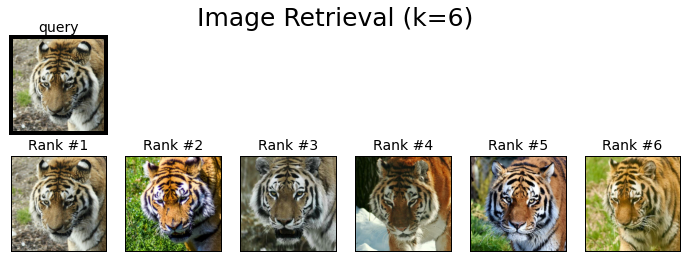

In [8]:
def get_n_images(query,knn,model):
  image = decode_image(query)
  image = tf.expand_dims(image,axis=0)
  query_feature = model.predict(image)
  flat_query_feature = query_feature.reshape((-1,np.prod(output_shape_model)))
  _, indices = knn.kneighbors(flat_query_feature)
  imgs_retrieval = [PATHS[idx] for idx in indices.flatten()]
  plot_query_retrieval(query, imgs_retrieval, None)

get_n_images('./dataset/0.jpg',knn,model)

Now lets check the code.


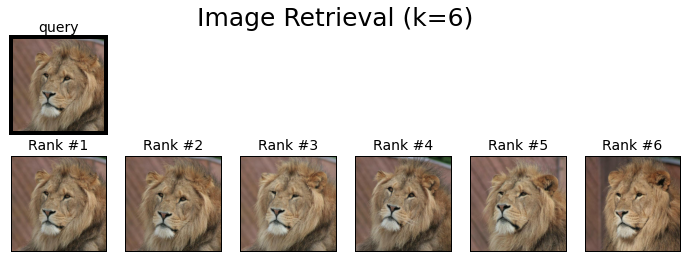

In [9]:
get_n_images('./dataset/3.jpg',knn,model)

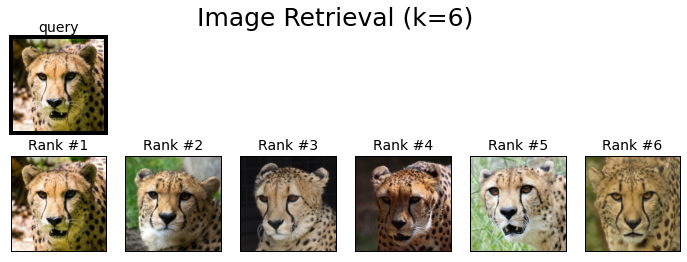

In [10]:
get_n_images('./dataset/9.jpg', knn, model)

lets try feature wise selection, zebra is black and white striped, thus we aim to see some thing striped in our results.

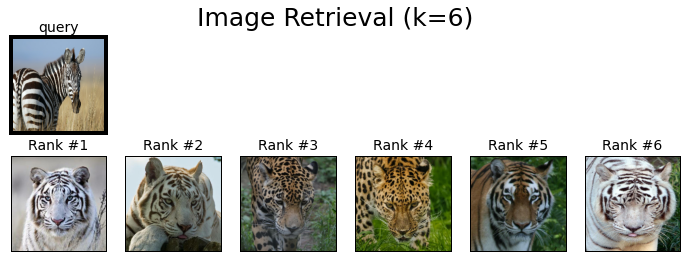

In [12]:
get_n_images('zebra.jpg', knn, model)

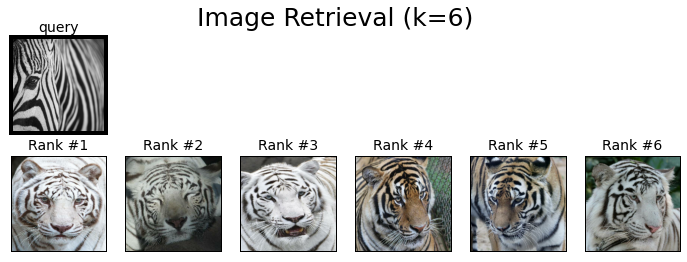

In [13]:
get_n_images('zebra2.jpg', knn, model)

So this model performs as aspected.